In [1]:
import matplotlib.pyplot as plt
import numpy as np
from uncertainties import ufloat
from uncertainties import unumpy as unp

from utils import load_data

In [2]:
dists = np.array([5, 10, 16, 22, 28, 34, 40])  # in cm
files = [f"data/Zeitkalibrierung-Na22-BaF2-{d}cm.Spe" for d in dists]

In [3]:
from lmfit.models import GaussianModel, LorentzianModel, VoigtModel,SkewedGaussianModel
factor = 2* np.sqrt(2*np.log(2))

def get_time_center(filepath: str, ax):
    dist = filepath.split("-")[3].split('.')[0]
    data, _ = load_data(filepath, only_roi=False)
    roi = np.arange(1950, 2350)
    data = data[roi]
    # model = SkewedGaussianModel()
    model = GaussianModel()

    # uncertainty of mcb is <1% differential nonlinearity, choose worst case
    adapted_data = data * 0.01
    adapted_data[adapted_data == 0.] = 1
    weights = np.array(1.0 / adapted_data)

    init_values = {
        'amplitude': {'value': 1900, 'min': 1600, 'max': 2000},
        'center': {'value': roi[np.where(data == max(data))[0][0]], 
                   'min': .9*roi[np.where(data == max(data))[0][0]], 
                   'max': 1.1*roi[np.where(data == max(data))[0][0]]},
        'sigma': {'value': 22, 'min': 19, 'max': 25},
        'gamma': {'value': 0, 'min': -2, 'max': 2},
    }
    params = model.make_params(**init_values)
    result = model.fit(data, params, x=list(roi), weights=weights)
    fitted_params = result.params
    fitted_params.pretty_print()

    x = np.linspace(min(roi), max(roi), 1000)
    y = model.eval(x=x, params=fitted_params)
    ax.plot(x, y, linewidth=.4, c='orange', label=f'Gauss-Fit: {dist}')
    ax.scatter(roi, data, s=1, label=f'{dist}')
    
    center = ufloat(fitted_params['center'].value, fitted_params['center'].stderr)
    fwhm = factor * ufloat(fitted_params['sigma'].value, fitted_params['sigma'].stderr)
    return [center, fwhm]

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude      1600     1600     2000    93.89     True     None     None
center         2246     2023     2473   0.4346     True     None     None
fwhm          44.74     -inf      inf   0.8181    False 2.3548200*sigma     None
height         33.6     -inf      inf     2.46    False 0.3989423*amplitude/max(1e-15, sigma)     None
sigma            19       19       25   0.3474     True     None     None
Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude      1925     1600     2000    58.33     True     None     None
center         2216     1994     2436   0.2888     True     None     None
fwhm          45.21     -inf      inf   0.4877    False 2.3548200*sigma     None
height           40     -inf      inf    1.507    False 0.3989423*amplitude/max(1e-15, sigma)     None
sigma          19.2       19       25   0.2071     True     None     None
Name          Value      Min      Ma

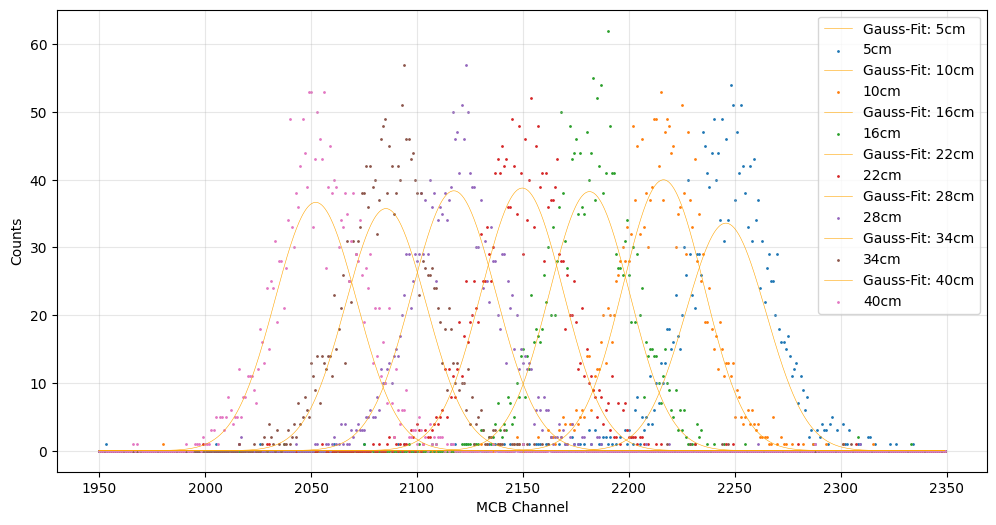

In [4]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
vals = []
stds = []
data = np.array([get_time_center(file, ax) for file in files]).T
centers = data[0]
fwhms = data[1]
for c in centers:
    vals.append(c.n)
    stds.append(c.s)
centers = unp.uarray(vals, stds)
plt.grid(alpha=.3)
plt.legend()
plt.xlabel('MCB Channel')
plt.ylabel('Counts')
plt.savefig('figures/Zeitpeaks.png', format='png', dpi=500, transparent=True)
plt.show()

In [5]:
cen_vals = unp.nominal_values(centers)
cen_stds = unp.std_devs(centers)

In [6]:
from lmfit.models import LinearModel

lin_model = LinearModel()
init_values_lin = {
    'slope': {'value': -0.17, 'min': -1, 'max': 0},
    'intercept': {'value': 2250, 'min': 2200, 'max': 2500},
}
params_lin = lin_model.make_params(**init_values_lin)

In [7]:
from scipy.constants import c

lightspeed = c * 100 * 10 ** -12  # in cm/ps
print('lightspeed:', lightspeed, 'cm/ps')
dists = np.array(dists - min(dists))
dists = unp.uarray(dists, np.zeros_like(dists) + .1)
times = np.array(dists) / lightspeed  # in ps
time_vals = unp.nominal_values(times)
time_stds = unp.std_devs(times)
print(times, "ps")

lightspeed: 0.0299792458 cm/ps
[0.0+/-3.335640951981521 166.78204759907604+/-3.335640951981521
 366.9205047179673+/-3.335640951981521
 567.0589618368585+/-3.335640951981521
 767.1974189557498+/-3.335640951981521
 967.335876074641+/-3.335640951981521
 1167.4743331935322+/-3.335640951981521] ps


In [8]:
cen_weights = 1.0 / (cen_stds + unp.std_devs(times))

In [9]:
print(fwhms)

[44.741580888128375+/-0.8180592204194772
 45.20603775977221+/-0.48770963027486985
 44.741580856429934+/-0.3134860453387574
 45.60290590582774+/-0.5479710743166344
 46.73383937028695+/-0.4722404124352554
 44.74158085776023+/-0.06997532242550084
 45.33272885864623+/-0.5278686775856186]


In [10]:
lin_result = lin_model.fit(cen_vals, params_lin, x=unp.nominal_values(times), weights=cen_weights)
fitted_params_lin = lin_result.params
fitted_params_lin.pretty_print()

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
intercept      2244     2200     2500    0.915     True     None     None
slope       -0.1646       -1        0 0.001315     True     None     None


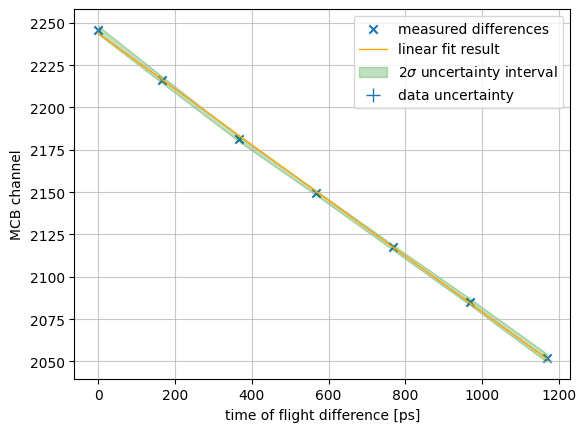

In [13]:
x = np.linspace(min(time_vals), max(time_vals), 10000)
y = lin_model.eval(x=x, params=fitted_params_lin)
uncert = lin_result.eval_uncertainty(x=time_vals, sigma=2)
plt.scatter(time_vals, cen_vals, label='measured differences', marker='x')
plt.errorbar(time_vals, cen_vals, xerr=time_stds, yerr=cen_stds, fmt='none', elinewidth=1, label='data uncertainty')
plt.plot(x, y, linewidth=1, c='orange', label='linear fit result')
plt.fill_between(time_vals, cen_vals - uncert, cen_vals + uncert, alpha=0.25, color='green',
                 label=r"$2\sigma$ uncertainty interval")
plt.grid(alpha=.7)
plt.legend()
plt.xlabel('time of flight difference [ps]')
plt.ylabel('MCB channel')
plt.savefig('figures/Zeiteichung.png', format='png', dpi=500, transparent=True)
plt.show()

In [12]:
time_resolution = abs(1. / ufloat(fitted_params_lin["slope"].value, fitted_params_lin["slope"].stderr))
print(f'Time resolution for BAF2 detector: {time_resolution} ps/channel')
print(rf'$\delta$ t_fwhm = {np.sum(fwhms*time_resolution)/len(fwhms)} ps')

Time resolution for BAF2 detector: 6.07+/-0.05 ps/channel
$\delta$ t_fwhm = 275.2+/-2.5 ps
